## Qualidade de Software, Segurança e Sistemas Inteligentes - Rodrigo Navarro
## MVP - Notebook de definição e implantação do modelo de Machine Learning

In [54]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from pickle import dump
from pickle import load

## Carga do Dataset

In [18]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/rodnav08/MVP_04/main/database/database_YT.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=';')

le = LabelEncoder()
dataset['Country'] = le.fit_transform(dataset['Country'])
dataset['Category'] = le.fit_transform(dataset['Category'])



# Mostra as primeiras linhas do dataset
dataset.head()

,subscribers,video views,uploads,Country,Category,video_views_for_the_last_30_days,highest_monthly_earnings,Pay well
0,245000000,228000000000,20082,17,8,2258000000,9000000,1
1,166000000,28368841870,741,44,4,1348000000,5400000,1
2,162000000,164000000000,966,44,3,1975000000,7900000,1
3,159000000,148000000000,116536,17,4,1824000000,7300000,1
4,112000000,93247040539,1111,44,4,731674000,2900000,1


## Separação em conjunto de treino e conjunto de teste com holdout

In [35]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 8 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:7]
y = array[:,7]
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação


# Parâmetros e partições da validação cruzada
scoring = 'recall'
num_particoes = 8
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

O meu modelo pretende classificar um canal de Youtube, dizendo se o dono do canal receberá ou não uma boa remuneração com os números atuais ou projetados de inscritos, views, país de origem, categoria do canal.
Considerando esse cenários de aceitação, o modelo deve ser testado utilizando dados de canais de sucesso e sem sucesso.
Para a avaliação, escolhi a métrica "recall" (percentual corretamente recuperado). Se o recall para canais de sucesso for acima de 90%, o modelo atenderá ao primeiro critério de aceitação. Se o recall para canais sem sucesso
também for acima de 90%, o sistema atenderá aos dois critérios de aceitação.

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.560030 (0.103510)
CART: 1.000000 (0.000000)
NB: 0.532362 (0.113128)
SVM: 0.318182 (0.119500)


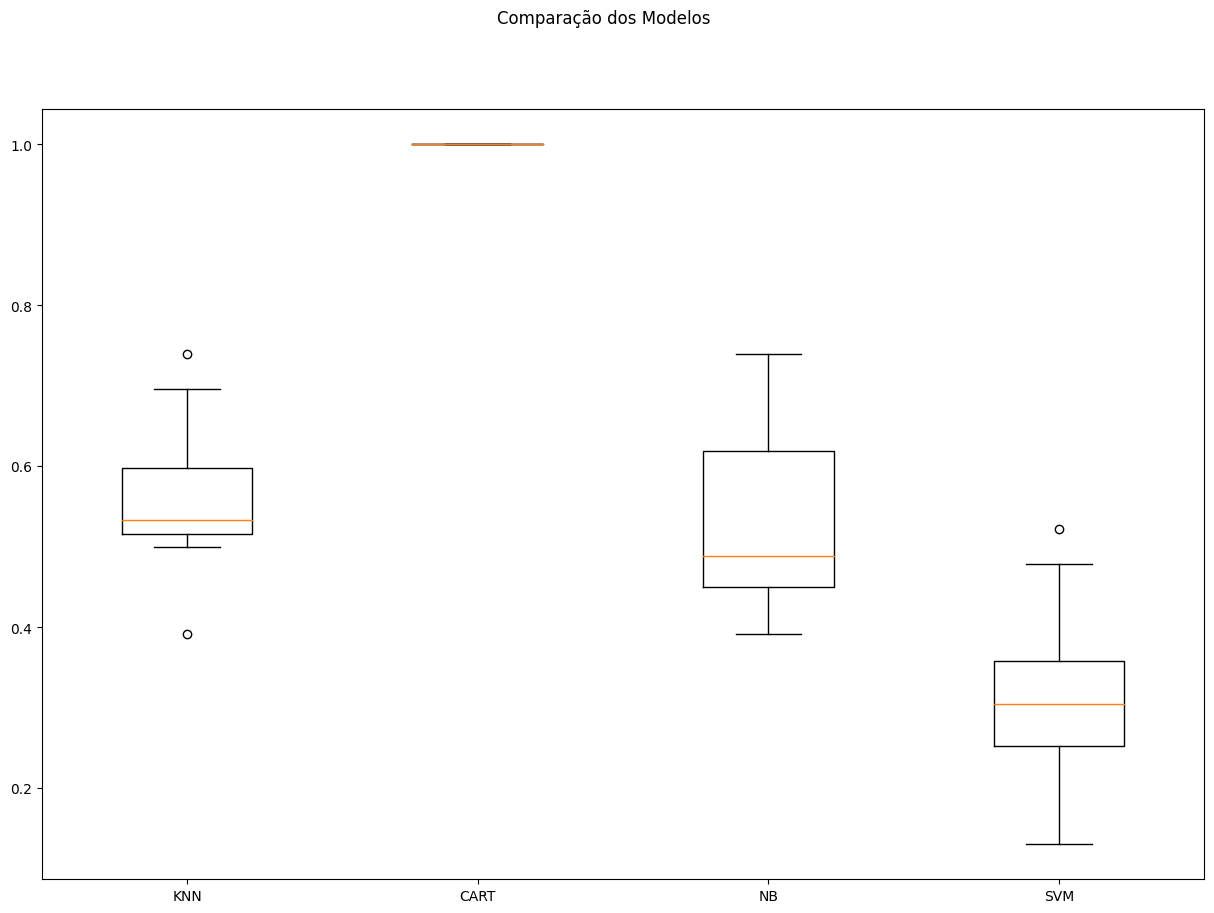

In [36]:
np.random.seed(8) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Nesta primeira análise, vemos que o método de arvore de decisão está "perfeito". Entretanto, ao implementar no backend só obtive resultados positivos (bool = 1). Prosseguindo com a normalização e padronização para a escolha do método. Se parasse aqui, escolheria o KNN que mostra os melhores resultados.


### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.560 (0.104)
CART-orig: 1.000 (0.000)
NB-orig: 0.532 (0.113)
SVM-orig: 0.318 (0.119)
KNN-padr: 0.768 (0.110)
CART-padr: 1.000 (0.000)
NB-padr: 0.785 (0.069)
SVM-padr: 0.802 (0.075)
KNN-norm: 0.593 (0.099)
CART-norm: 1.000 (0.000)
NB-norm: 0.785 (0.069)
SVM-norm: 0.604 (0.090)


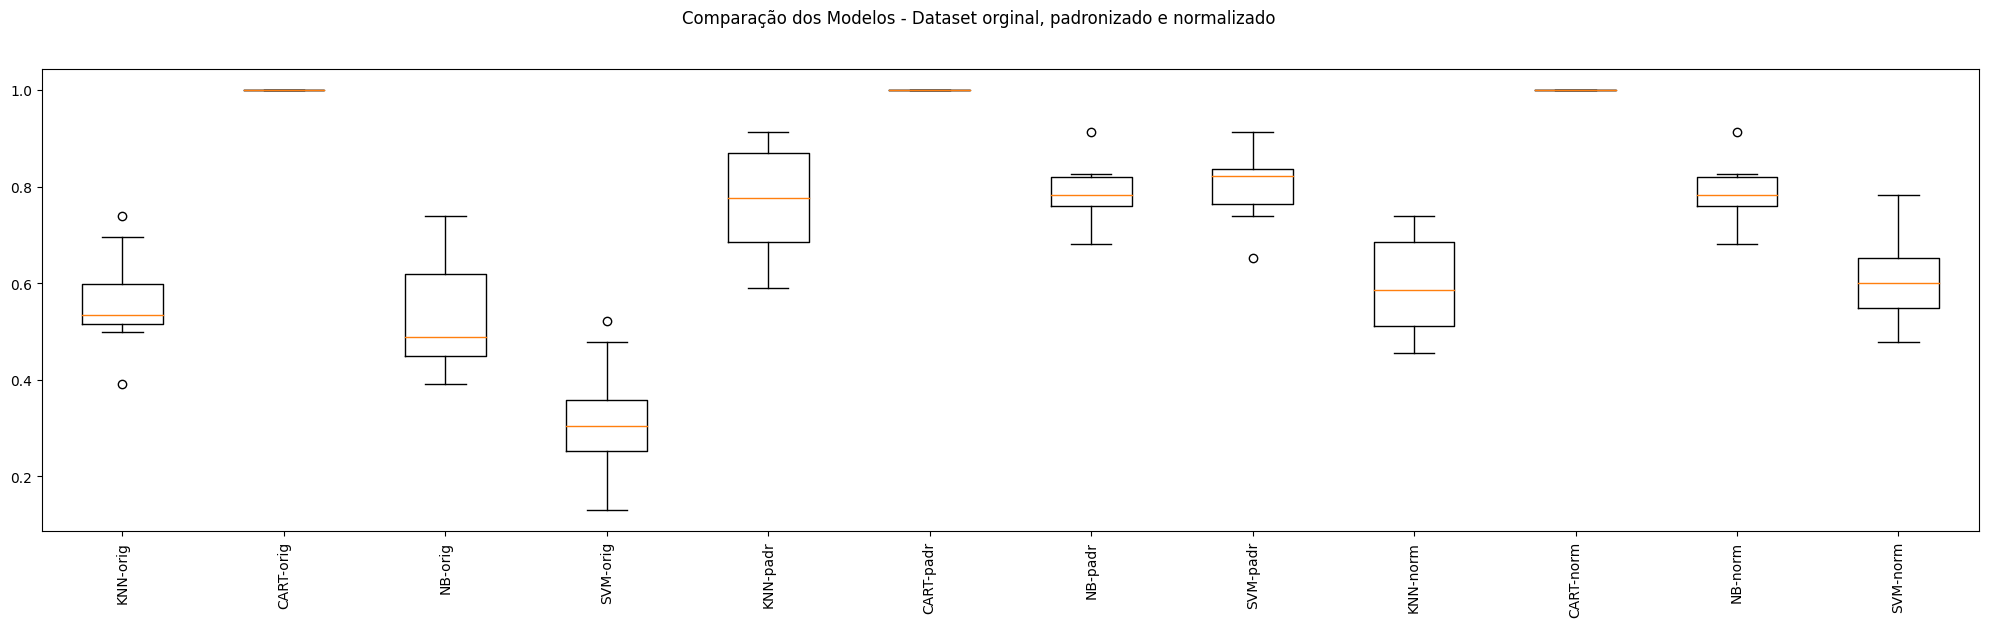

In [39]:
np.random.seed(8) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Já nesta segunda análise, descartando o método Arvore de Decisão, vemos que o melhor método é o SVM padronizado que ja consegue atingir um patamar de 80% no score recall com desvio de 7,5%.

### Otimização dos hiperparâmetros

In [55]:
# Tuning do SVM

np.random.seed(8) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('svm-orig', Pipeline(steps=[svm])))
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))

param_grid = {
    'SVM__kernel': ['rbf','polynomial'],
    'SVM__C': [3.0, 1.0, 5.0],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: svm-orig - Melhor: 0.356719 usando {'SVM__C': 5.0, 'SVM__kernel': 'rbf'}
Sem tratamento de missings: svm-padr - Melhor: 0.912549 usando {'SVM__C': 5.0, 'SVM__kernel': 'rbf'}
Sem tratamento de missings: svm-norm - Melhor: 0.725049 usando {'SVM__C': 5.0, 'SVM__kernel': 'rbf'}


Após o tunning do SVM, percebe-se que o SVM padronizado mantém a melhor aderência, e melhora seu resultado com constante de rigidez C=5.0. O tunning não gerou mudanças no Kernel.

## Finalização do Modelo

In [60]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = SVC(C=5.0,kernel='rbf')
#DecisionTreeClassifier()
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.9683544303797469


Finalizando o modelo com a padronização e mudança na constante de rigidez, vemos que o accuracy_score atende o critério estipulado de 90%

In [50]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

SVC(C=5.0)

## Simulando a aplicação do modelo em dados não vistos

In [51]:
dataset.head()

,subscribers,video views,uploads,Country,Category,video_views_for_the_last_30_days,highest_monthly_earnings,Pay well
0,245000000,228000000000,20082,17,8,2258000000,9000000,1
1,166000000,28368841870,741,44,4,1348000000,5400000,1
2,162000000,164000000000,966,44,3,1975000000,7900000,1
3,159000000,148000000000,116536,17,4,1824000000,7300000,1
4,112000000,93247040539,1111,44,4,731674000,2900000,1


In [52]:
# Novos dados
data = {'subscribers':  [26800674545, 2733, 1961],
        'video views': [303780000, 1149000000, 1597],
         'uploads': [750, 966, 11],
        'Country': [19, 47, 19],
        'Category': [4, 3, 8],
        'video_views_for_the_last_30_days': [815949000, 528392000, 20],
        'highest_monthly_earnings': [2400000.00, 928100.00, 18.00],
        }

atributos = ['subscribers', 'video views', 'uploads', 'Country', 'Category', 'video_views_for_the_last_30_days', 'highest_monthly_earnings']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:7].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 1.52300841e+03 -7.99247925e-01 -2.61983718e-01 -7.87893656e-01
  -7.80941447e-01  1.43955232e+00  1.40414490e+00]
 [-1.42134694e+00 -7.44176439e-01 -2.55836335e-01  1.10161423e+00
  -1.14275167e+00  7.85119760e-01  2.15098648e-01]
 [-1.42139085e+00 -8.19041030e-01 -2.83015737e-01 -7.87893656e-01
   6.66299426e-01 -4.17413704e-01 -5.34634641e-01]]


In [33]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[1 1 0]


*texto em itálico*#Impantação do ML


In [53]:
# Salva o modelo no disco
filename = 'model.pkl'
dump(model, open(filename, 'wb'))
# Salva o scaler no disco
filename = 'scaler.pkl'
dump(scaler, open(filename, 'wb'))

#Conclusão

Conforme abordado durante todo o documento, analisei quatro metodologias: KNN, SVM, CATR e NB. Dentre elas, o CATR inicialmente foi o melhor. Entretanto quando implemente o backend não obtive bons resultados. Isso pode ter ocorrido por não ter adotado algumas práticas que adotei depois como a utilização do sclaer no backend antes de chamar a função predict. De qualquer forma, decidi ignorar o método de arvore de decisão e analisar os demais.

Neste processo, escolhi o SVM já que foi o melhor método após a padronização. Ainda assim, no tunning, consegui resultados ainda melhores alterando a constante de rigidez para 5.0. Finalmente, exportei o modelo padronizado e modificado assim como o scaler para utilização no backend
